# **CycleGANs for Generating Ukiyo-e Art**

####Anshika Gupta, Niegil Francis, Sakthisree, Vishnu M

This is our project report/paper review for AI-4B at Univ.AI where we review the CycleGAN [paper](https://www.cs.cmu.edu/~junyanz/projects/CycleGAN/CycleGAN.pdf). We worked on generating Ukiyo-e art with CycleGANs.

GOAL: The goal of this paper was to develop a system that can
learn to figure out how to translate the style
of one set of images to the style of another, in the absence
of paired training examples.

##**Introduction**

Image-to-image translation involves generating a new synthetic version of a given image with a specific modification. The CycleGAN is a technique that involves the automatic training of image-to-image translation models. The models are trained in an unsupervised manner using a collection of images from the source and target domain that do not need to be related in any way.
The core idea was to build and understand a CycleGAN to generate Ukiyo-e art.


##**Why CycleGANs over GANs for Image-to-Image Translation?**

Unlike other GAN models for image translation, the CycleGAN does not require a dataset of paired images. For example, if we are interested in translating photographs of oranges to apples, we do not require a training dataset of oranges that have been manually converted to apples. This allows the development of a translation model on problems where training datasets may not exist, such as translating paintings to photographs.

Instead, the model is able to use a collection of photographs from each domain and extract and harness the underlying style of images in the collection in order to perform the translation.

###The Model Architecture

The model architecture is comprised of two generator models: one generator (Generator-A) for generating images for the first domain (Domain-A) and the second generator (Generator-B) for generating images for the second domain (Domain-B). Generator-A takes an image from Domain-B as input and Generator-B takes an image from Domain-A as input.

Each generator has a corresponding discriminator model. The first discriminator model (Discriminator-A) takes real images from Domain-A and generated images from Generator-A and predicts whether they are real or fake. The second discriminator model (Discriminator-B) takes real images from Domain-B and generated images from Generator-B and predicts whether they are real or fake.

The discriminator and generator models are trained in an adversarial zero-sum process, like normal GAN models. The generators learn to better fool the discriminators and the discriminator learn to better detect fake images. Together, the models find an equilibrium during the training process.

In [ ]:
# Importing the necessary libraries

from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

from os import listdir
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

###Dataset Preparation

The problem statement stated that we have to use CycleGANs for generating Ukiyo-e art. We considered this as a paper review and invested more time in understanding the paper, the models, and loss functions than getting perfect outputs. The link to the dataset is [here]("https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/ukiyoe2photo.zip").

The dataset directory had folders named 'trainA', 'trainB', 'testA', 'testB'. A corresponds to the paintings and B corresponds to pictures. We used the following code to load all photographs from the train and test folders and create an array of images for category A and another for category B.

Both arrays are then saved to a new file in compressed NumPy array format (.npz file because it is convenient and because raw pixels can take up a lot of space).


In [ ]:
# Preparing the Dataset
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path = 'ukiyoe2photo/'
# load dataset A
dataA1 = load_images(path + 'trainA/')
dataAB = load_images(path + 'testA/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path + 'testB/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'photo2img.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

We can then load the dataset and plot some of the photos to confirm that we are handling the image data correctly.



Loaded:  (825, 256, 256, 3) (7038, 256, 256, 3)


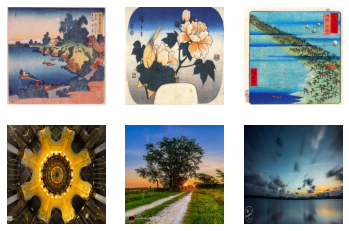

In [13]:
# load and plot the prepared dataset
# load the dataset
data = load('/content/CycleGANs-for-Ukiyo-e-art/photo2img.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

Now that we have prepared the dataset for modeling, we can develop the CycleGAN generator models that can translate photos from one category to the other, and the reverse.

As mentioned, the architecture is comprised of four models, two discriminator models, and two generator models.

## The Discriminator

As the paper reads, for discriminator networks,
we use 70 x 70 PatchGAN. Let Ck denote
a 4 x 4 Convolution-BatchNorm-LeakyReLU layer with
k filters and stride 2. After the last layer, we apply a
convolution andto produce a 1 dimensional output. We do
not use BatchNorm for the first C64 layer. We use leaky
ReLUs with slope 0.2. The discriminator architecture is:
C64-C128-C256-C512.

The paper mentions that the Discriminator uses InstanceNormalization instaed of BatchNormalization. It is a very simple type of normalization and involves standardizing (e.g. scaling to a standard Gaussian) the values on each output feature map, rather than across features in a batch.

For that purpose we will use the keras-contrib project implementation of Instance Normalization.

In [10]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ia0_94eh
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ia0_94eh
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=ecd0390b12932eefdae2a199ad227db568663b6c56040e8faba7e67800c92d04
  Stored in directory: /tmp/pip-ephem-wheel-cache-m89cc1f2/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


The define_discriminator() function below implements the 70×70 PatchGAN discriminator model as per the design of the model in the paper. The model takes a 256×256 sized image as input and outputs a patch of predictions. The model is optimized using least squares loss (L2) implemented as mean squared error, and a weighting it used so that updates to the model have half (0.5) the usual effect. The authors of CycleGAN paper recommend this weighting of model updates to slow down changes to the discriminator, relative to the generator model during training.

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

## The Generator

As mentioned in the paper, 6 blocks are used for 128 x 128
training images, and 9 blocks for 256 x 256 or higherresolution
training images.

#### The ResNet Block

Following is the code for resnet block that we will be using for our generator model. This function creates two Convolution-InstanceNorm blocks with 3×3 filters and 1×1 stride and without a ReLU activation after the second block.

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

Importantly, the model outputs pixel values with the shape as the input and pixel values are in the range [-1, 1], typical for GAN generator models.



In [ ]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

## Loss Functions:
Each generator model is optimized via the combination of four outputs with four loss functions:

- Adversarial loss (L2 or mean squared error).
- Identity loss (L1 or mean absolute error).
- Forward cycle loss (L1 or mean absolute error).
- Backward cycle loss (L1 or mean absolute error).

We achieved this by defining a composite model used to train each generator model that is responsible for only updating the weights of that generator model, although it is required to share the weights with the related discriminator model and the other generator model.

### Adversarial loss: 

The discriminator models are trained directly on real and generated images, whereas the generator models are not. Instead, the generator models are trained via their related discriminator models. Specifically, they are updated to minimize the loss predicted by the discriminator for generated images marked as "real", called adversarial loss. As such, they are encouraged to generate images that better fit into the target domain.

### Identity Loss:

The generator models are also updated based on how effective they are at the regeneration of a source image when used with the other generator model, called cycle loss. Finally, a generator model is expected to output an image without translation when provided an example from the target domain, called identity loss.

### Cycle Loss:

For each image x from domain X, the image translation cycle
should be able to bring x back to the original image, i.e.
x ⟶ G(x) ⟶ F(G(x)) ~ x. We call it forward cycle consistency.


Similarly, for each image y from domain Y , G and F should also satisfy the backward cycle consistency: y ⟶ F(y) ⟶ G(F(y)) ~ y.


In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

##Loading and preparing the dataset and generating real and fake sample batches

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

## Training
Typically, GAN models do not converge; instead, an equilibrium is found between the generator and discriminator models. As such, we cannot easily judge whether training should stop. Therefore, we can save the model and use it to generate sample image-to-image translations periodically during training, such as every one or five training epochs.

The save_models() function below will save each generator model to the current directory in H5 format, including the training iteration number in the filename. 



In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

The summarize_performance() function below uses a given generator model to generate translated versions of a few randomly selected source photographs and saves the plot to file.

The source images are plotted on the first row and the generated images are plotted on the second row. The plot filename includes the training iteration number.

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

The paper defines an image pool of 50 generated images for each discriminator model that is first populated and probabilistically either adds new images to the pool by replacing an existing image or uses a generated image directly. We can implement this as a Python list of images for each discriminator and use the update_image_pool() function below to maintain each pool list.

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

The train() function below takes all six models (two discriminator, two generator, and two composite models) as arguments along with the dataset and trains the models.

Loss for each of the updated models is then reported at the end of the training iteration. Importantly, only the weighted average loss used to update each generator is reported.

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

The loss is reported each training iteration, including the Discriminator-A loss on real and fake examples (dA), Discriminator-B loss on real and fake examples (dB), and Generator-AtoB and Generator-BtoA loss, each of which is a weighted average of adversarial, identity, forward, and backward cycle loss (g).

Models are saved after every five epochs or (562 * 5) 2,810 training iterations, and again the iteration number is used in the filenames.

In [12]:
# load image data
dataset = load_real_samples('photo2img.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (825, 256, 256, 3) (7038, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
>41581, dA[0.002,0.002] dB[0.003,0.068] g[3.158,3.549]
>41582, dA[0.002,0.004] dB[0.003,0.005] g[4.550,5.347]
>41583, dA[0.004,0.003] dB[0.080,0.006] g[3.377,3.263]
>41584, dA[0.002,0.002] dB[0.007,0.048] g[3.536,3.976]
>41585, dA[0.002,0.002] dB[0.003,0.038] g[3.109,3.485]
>41586, dA[0.004,0.002] dB[0.002,0.035] g[3.217,4.017]
>41587, dA[0.011,0.002] dB[0.006,0.004] g[4.327,4.119]
>41588, dA[0.002,0.001] dB[0.003,0.013] g[4.842,4.939]
>41589, dA[0.002,0.003] dB[0.008,0.014] g[4.328,4.598]
>41590, dA[0.002,0.045] dB[0.443,0.016] g[4.763,4.756]
>41591, dA[0.001,0.002] dB[0.207,0.170] g[4.568,5.344]
>41592, dA[0.001,0.002] dB[0.017,0.049] g[4.998,6.340]
>41593, dA[0.006,0.001] dB[0.133,0.006] g[3.760,3.570]
>41594, dA[0.002,0.002] dB[0.021,0.035] g[3.394,4.103]
>41595, dA[0.007,0.003] dB[0.014,0.021] g[4.404,4.938]
>41596, dA[0.008,0.004] dB[0.005,0.229] g[2.957,4.089]
>41597, dA[0.007,0.004] dB[0.006,0.042] g[3.063,3.988]
>41598, dA[0.0

KeyboardInterrupt: ignored

Plots of generated images are saved at the end of every epoch or after every 562 training iterations and the iteration number is used in the filename.

---
The plots of generated images can be used to choose a model and more training iterations may not necessarily mean better quality generated images.




##Ukiyo-e art generation With CycleGAN Generators

In [ ]:
# example of using saved cyclegan models for image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
A_data, B_data = load_real_samples('photo2img.npz')
print('Loaded', A_data.shape, B_data.shape)
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_045375.h5', cust)
model_BtoA = load_model('g_model_BtoA_045375.h5', cust)
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

##Results

We trained for approximately around 46 thousand iterations until our dA and dB losses started dropping between 0.005 to 0.5.

BtoA_generated_plot: 


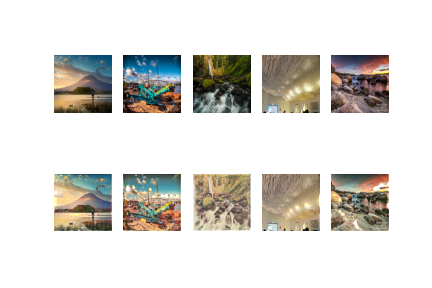

AtoB_generated_plot:


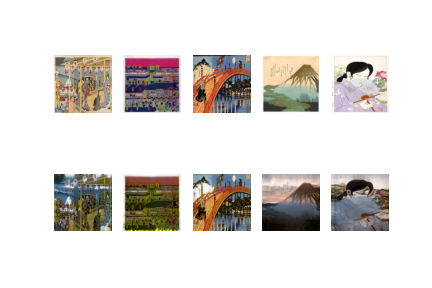